# Problem Statement

Conducting Named Entity Recognition on various tweets

## Downloading Data

In [ ]:
!gdown 14_VHffl1qBUEnZ1IWFHnh6B9M5_A-Wf8
!gdown 1cnrGjppPOU_NtHNpGu0RJGg1CUNNsse_

Downloading...
From: https://drive.google.com/uc?id=14_VHffl1qBUEnZ1IWFHnh6B9M5_A-Wf8
To: /content/wnut 16.txt.conll
100% 403k/403k [00:00<00:00, 34.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cnrGjppPOU_NtHNpGu0RJGg1CUNNsse_
To: /content/wnut 16test.txt.conll
100% 635k/635k [00:00<00:00, 60.3MB/s]


## Installing Libraries

In [ ]:
%pip install pandas numpy nltk transformers spacy tensorflow keras scikit-learn matplotlib seaborn gensim datasets tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow

In [ ]:
import pandas as pd
import tensorflow as tf

## Loading Data from Files

In [ ]:
def read_conll(file_path):
    sentences = []
    sentence = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.strip() == "":
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                word, label = line.strip().split()
                sentence.append((word, label))
    if sentence:
        sentences.append(sentence)
    return sentences

# Example usage:
train_file = 'wnut 16.txt.conll'
test_file = 'wnut 16test.txt.conll'

train_data = read_conll(train_file)
test_data = read_conll(test_file)


## Data Structure

In [ ]:
# Display some example sentences from the training data
for i in range(2):
    print(train_data[i])

[('@SammieLynnsMom', 'O'), ('@tg10781', 'O'), ('they', 'O'), ('will', 'O'), ('be', 'O'), ('all', 'O'), ('done', 'O'), ('by', 'O'), ('Sunday', 'O'), ('trust', 'O'), ('me', 'O'), ('*wink*', 'O')]
[('Made', 'O'), ('it', 'O'), ('back', 'O'), ('home', 'O'), ('to', 'O'), ('GA', 'B-geo-loc'), ('.', 'O'), ('It', 'O'), ('sucks', 'O'), ('not', 'O'), ('to', 'O'), ('be', 'O'), ('at', 'O'), ('Disney', 'B-facility'), ('world', 'I-facility'), (',', 'O'), ('but', 'O'), ('its', 'O'), ('good', 'O'), ('to', 'O'), ('be', 'O'), ('home', 'O'), ('.', 'O'), ('Time', 'O'), ('to', 'O'), ('start', 'O'), ('planning', 'O'), ('the', 'O'), ('next', 'O'), ('Disney', 'B-facility'), ('World', 'I-facility'), ('trip', 'O'), ('.', 'O')]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

## Exploratory Data Analysis: Examining Tag Distribution

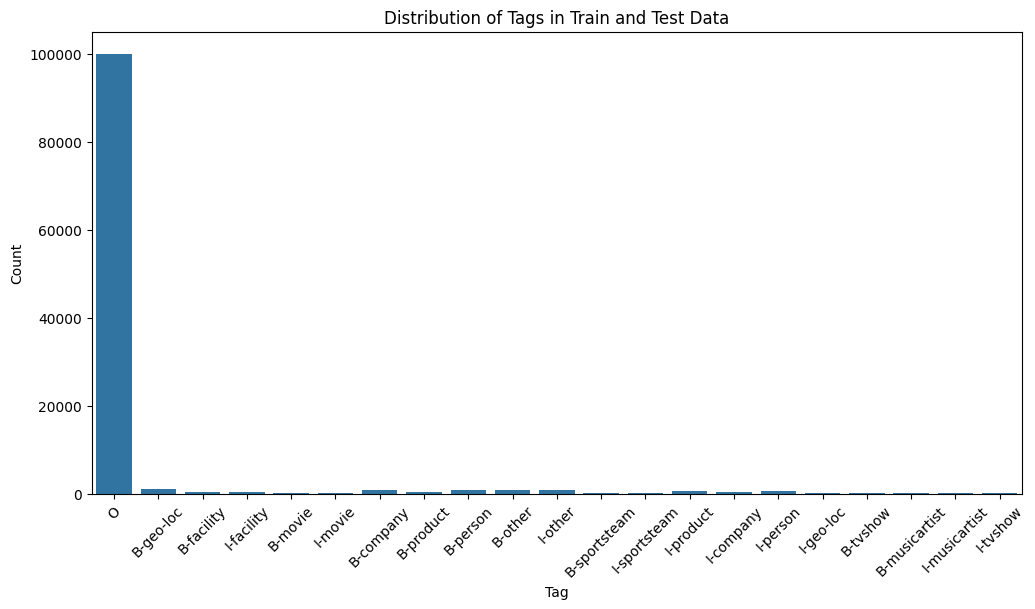

In [ ]:
# Combine the data
combined_data = train_data + test_data

# Flatten the list of sentences to get all labels
labels = [label for sentence in combined_data for _, label in sentence]

# Count the occurrences of each label
label_distribution = Counter(labels)

# Convert the counter to a DataFrame for easy plotting
df = pd.DataFrame.from_dict(label_distribution, orient='index').reset_index()
df.columns = ['Tag', 'Count']

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Tag', y='Count', data=df)
plt.title('Distribution of Tags in Train and Test Data')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

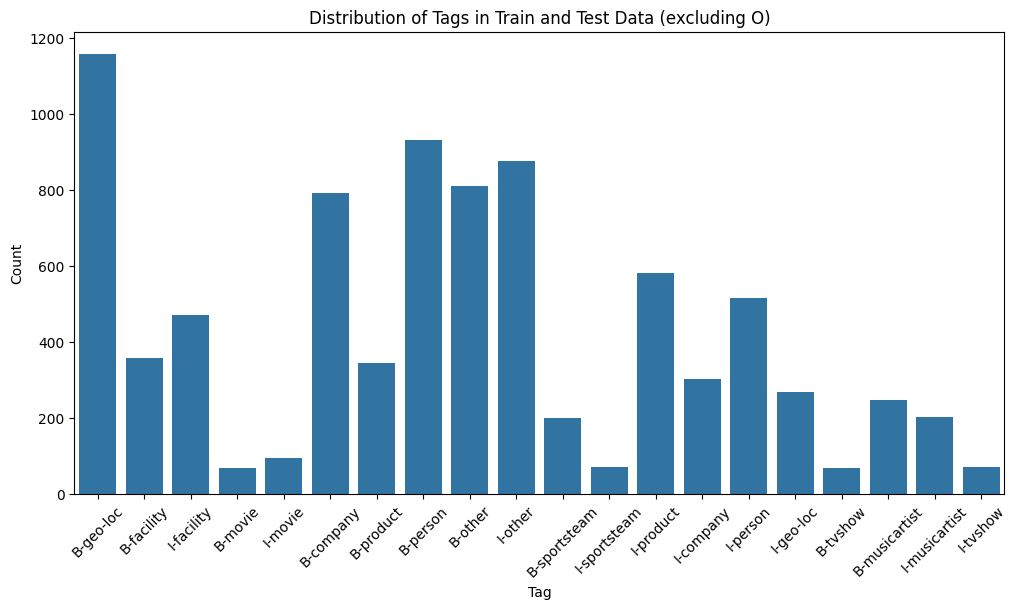

In [ ]:
# Count the occurrences of each label
label_distribution = Counter(labels)

# Remove the 'O' tag from the distribution
if 'O' in label_distribution:
    del label_distribution['O']

# Convert the counter to a DataFrame for easy plotting
df = pd.DataFrame.from_dict(label_distribution, orient='index').reset_index()
df.columns = ['Tag', 'Count']

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Tag', y='Count', data=df)
plt.title('Distribution of Tags in Train and Test Data (excluding O)')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Obtaining Vocabulary size and max length

In [ ]:
def get_vocab_size_and_max_length(data):
    words = [word for sentence in data for word, label in sentence]
    word_counter = Counter(words)
    vocab_size = len(word_counter)
    max_length = max(len(sentence) for sentence in data)
    return vocab_size, max_length

# Calculate for train and test data separately and combined
train_vocab_size, train_max_length = get_vocab_size_and_max_length(train_data)
test_vocab_size, test_max_length = get_vocab_size_and_max_length(test_data)
combined_vocab_size, combined_max_length = get_vocab_size_and_max_length(combined_data)

print(f"Train Vocab Size: {train_vocab_size}")
print(f"Train Max Length: {train_max_length}")

print(f"Test Vocab Size: {test_vocab_size}")
print(f"Test Max Length: {test_max_length}")

print(f"Combined Vocab Size: {combined_vocab_size}")
print(f"Combined Max Length: {combined_max_length}")

Train Vocab Size: 10586
Train Max Length: 39
Test Vocab Size: 18320
Test Max Length: 35
Combined Vocab Size: 25383
Combined Max Length: 39


## Training the LSTM + CRF Model:


In [ ]:
import gensim.downloader as api
word2vec = api.load("glove-twitter-200") # Loading glove-twitter model
embedding_dim = 200

[==================================================] 100.0% 758.5/758.5MB downloaded


### Training a Tokenizer for LSTM Input Embeddings

In [ ]:
all_sentences = [] # Concating test, train sentences. To train a tokenizer
for sample in all_samples:
  sentence = [tag[0] for tag in sample]
  all_sentences.append(sentence)

crf_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words, lower=True)
crf_tokenizer.fit_on_texts(all_sentences)

In [ ]:
import numpy as np
num_tokens = len(crf_tokenizer.word_index) + 1
hits = 0
misses = 0
missed_words = []


# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in crf_tokenizer.word_index.items():
  embedding_vector = None
  try:
    embedding_vector = word2vec[word]
  except Exception :
    pass

  if embedding_vector is not None:
    # Words not found in embedding index will be all-zeros.
    # This includes the representation for "padding" and "OOV"
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    missed_words.append(word)
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 11495 words (10438 misses)


## Creating the Training Dataset

In [ ]:
tag2id = {} # Label to indicies mapping
id2tag = {} # Index to label mapping
for i, tag in enumerate(schema):
  tag2id[tag] = i
  id2tag[i] = tag

In [ ]:
def get_dataset(samples, max_len, tag2id, tokenizer):
  '''Prepares the input dataset

  Args:
    `samples`: List[List[Tuple[word, tag]]], input data
    `max_len`: Maximum input length
    `tag2id`: Mapping[tag: integer]
    `tokenizer`: Tensorflow tokenizer, for tokenizing input sequence

  Returns:
    Tuple[np.ndarray, np.ndarray]: sentences and it's labels
  '''
  dataset = {'samples':[], 'labels': []}

  for sample in samples:
    # Extracting inputs and labels
    inputs = [x[0] for x in sample]
    outputs = [x[1] for x in sample]

    # Tokenizing inputs
    inputs = tokenizer.texts_to_sequences([inputs])[0]

    # padding labels
    padded_inputs = [inputs[i] if i < len(inputs) else 0 for i in range(max_len)]

    # Initializing labels as One Hot Encoded Vectors
    padded_labels = [[0 for i in range(len(tag2id))] for j in range(max_len)]
    for i in range(len(outputs)):
      padded_labels[i][tag2id[outputs[i]]] = 1

    # Adding padded inputs & labels to dataset
    dataset['samples'].append(padded_inputs)
    dataset['labels'].append(padded_labels)

  return np.array(dataset['samples']), np.array(dataset['labels'])

train_sentences, train_labels = get_dataset(train_samples, max_len, tag2id, crf_tokenizer)
test_sentences, test_labels = get_dataset(test_samples, max_len, tag2id, crf_tokenizer)

# Training Our Model

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow_addons.utils.types import FloatTensorLike, TensorLike

# LSTM components
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

# CRF layer
from tensorflow_addons.layers import CRF

# Sigmoid focal cross entropy loss. works well with highly unbalanced input data
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW


def build_model():
  # Model definition
  input = Input(shape=(max_len,))

  # Get embeddings
  embeddings = Embedding(input_dim=embedding_matrix.shape[0],
                      output_dim=embedding_dim,
                      input_length=max_len, mask_zero=True,
                      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
                    )(input)

  # variational biLSTM
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embeddings)

  # Stacking
  output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

  # Adding more non-linearity
  dense_out = TimeDistributed(Dense(25, activation="relu"))(output_sequences)

  # CRF layer
  crf = CRF(len(schema), name='crf')
  predicted_sequence, potentials, sequence_length, crf_kernel = crf(dense_out)

  model = Model(input, potentials)
  model.compile(
      optimizer=AdamW(weight_decay=0.001),
      loss= SigmoidFocalCrossEntropy()) # Sigmoid focal cross entropy loss

  return model

model = build_model()

# Checkpointing
save_model = tf.keras.callbacks.ModelCheckpoint(filepath='twitter_ner_crf.h5',
  monitor='val_loss',
  save_weights_only=True,
  save_best_only=True,
  verbose=1
)

# Early stoppings
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=1)

callbacks = [save_model, es]

model.summary()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 200)           4386800   
                                                                 
 bidirectional (Bidirection  (None, 39, 100)           100400    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 39, 100)           60400     
 onal)                                                           
                                                                 
 time_distributed (TimeDist  (None, 39, 25)            2525      
 ributed)                                                        
                                                             

# Loading the Best Model

In [ ]:
model.fit(train_sentences, train_labels,
          validation_data = (test_sentences, test_labels),
          epochs = 300,
          callbacks  = callbacks,
          shuffle=True)

Epoch 1/300


194/196 [============================>.] - ETA: 0s - loss: 0.0850
Epoch 1: val_loss improved from inf to 0.04047, saving model to twitter_ner_crf.h5
196/196 [==============================] - 35s 60ms/step - loss: 0.0847 - val_loss: 0.0405
Epoch 2/300
194/196 [============================>.] - ETA: 0s - loss: 0.0353
Epoch 2: val_loss improved from 0.04047 to 0.03353, saving model to twitter_ner_crf.h5
196/196 [==============================] - 6s 31ms/step - loss: 0.0353 - val_loss: 0.0335
Epoch 3/300
196/196 [==============================] - ETA: 0s - loss: 0.0266
Epoch 3: val_loss improved from 0.03353 to 0.02444, saving model to twitter_ner_crf.h5
196/196 [==============================] - 9s 48ms/step - loss: 0.0266 - val_loss: 0.0244
Epoch 4/300
194/196 [============================>.] - ETA: 0s - loss: 0.0213
Epoch 4: val_loss improved from 0.02444 to 0.01983, saving model to twitter_ner_crf.h5
196/196 [==============================] - 7s 36ms/step - loss: 0.0213 - val_loss: 0.

### Calculating the Model's Average Accuracy on the Test Set

In [ ]:
model.load_weights('twitter_ner_crf.h5')

In [ ]:
crf_model = tf.keras.Model(inputs=model.input, outputs=[model.output, model.get_layer('crf').output, model.input])

# BERT Model

In [ ]:
def calculate_accuracy(y_true, y_pred):
  '''Convert categorical one hot encodings to indices and compute accuracy

  Args:
    `y_true`: true values
    `y_pred`: model predictions

  Returns:
    Integer, accuracy of prediction
  '''
  acc_metric = tf.keras.metrics.Accuracy()
  y_true = tf.argmax(y_true, axis=-1)
  return acc_metric(y_true, y_pred).numpy().item()

def calculate_mosacy(crf_model, test_sentences, test_labels):
  '''Calculates average validation accuracy of model'''

  # Batch the dataset
  batched_validation_set = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels)).batch(32)

  average_acc = 0
  # Iterate through batches
  for batch_test_sentences, batch_test_labels in batched_validation_set:
    predicted_labels, _, _, _ = crf_model(batch_test_sentences)[1]
    average_acc += calculate_accuracy(batch_test_labels, predicted_labels)

  average_acc/=len(batched_validation_set)
  return average_acc

average_acc = calculate_mosacy(crf_model, test_sentences, test_labels)

print("*"*32)
print(f"Average accuracy of model on test set: {average_acc:.3f}")

********************************
Average accuracy of model on test set: 0.961


## Obtaining the BERT Model

# Loading the Tokenizer

In [ ]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-uncased'

- The tokenizer adds token IDs 101 and 102 at the start and end of tokens
- Using [1:-1] to remove the extra 101 and 102 tokens added by the tokenizer
- Let's take a look at the tokenization of a training sample

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # Load bert-base-uncased tokenizer

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Retrieving Datasets

In [ ]:
sample=train_samples[10] # Random tokenized sample
for token, tag in sample:
  for subtoken in tokenizer(token)['input_ids'][1:-1]:
    print(token,subtoken)

RT 19387
@Hatshepsutely 1030
@Hatshepsutely 16717
@Hatshepsutely 5369
@Hatshepsutely 4523
@Hatshepsutely 10421
@Hatshepsutely 2135
: 1024
@adamlambert 1030
@adamlambert 4205
@adamlambert 10278
@adamlambert 8296
please 3531
, 1010
oh 2821
please 3531
wear 4929
the 1996
infamous 14429
beach 3509
hat 6045
tonight 3892
during 2076
your 2115
encore 19493
( 1006
in 1999
lieu 22470
of 1997
a 1037
rasta 20710
rasta 2696
wig) 24405
wig) 1007
. 1012
&lt; 1004
&lt; 8318
&lt; 1025
3333 21211
3333 2509


## Loading the Model

In [ ]:
import numpy as np
import tqdm

def tokenize_sample(sample):
  # Expand label to all subtokens and add 'O' label to start and end tokens
  seq = [
    (subtoken, tag)
    for token, tag in sample
    for subtoken in tokenizer(token.lower())['input_ids'][1:-1]
  ]
  return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples, tag2id):
  tokenized_samples = list((map(tokenize_sample, samples)))
  max_len = max(map(len, tokenized_samples))

  # Subtokens
  X_input_ids = np.zeros((len(samples), max_len), dtype=np.int32)

  # Masks
  X_input_masks = np.zeros((len(samples), max_len), dtype=np.int32)

  # labels
  y = np.zeros((len(samples), max_len), dtype=np.int32)

  for i, sentence in enumerate(tokenized_samples):
    for j in range(len(sentence)):
      X_input_masks[i, j] = 1
    for j, (subtoken_id, tag) in enumerate(sentence):
      X_input_ids[i, j] = subtoken_id
      y[i, j] = tag2id[tag]
  return (X_input_ids, X_input_masks), y

X_train, y_train = preprocess(train_samples, tag2id)
X_test, y_test = preprocess(test_samples, tag2id)

### Fitting the Model on Training Data

In [ ]:
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema),
                                    id2tag=id2tag, tag2id=tag2id) # Bert config

model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME,
                                                          config=config) # Loading Bert model
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  16918     
                                                                 
Total params: 108908566 (415.45 MB)
Trainable params: 108908566 (415.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


- Presenting a side-by-side view of true labels and model predictions
- Arranged as an array of Tuples (token, true label, model prediction)

In [ ]:
BATCH_SIZE=32

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Creating optimizer

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

history = model.fit(X_train, y_train,
                  validation_split=0.2, epochs=10,
                  batch_size=BATCH_SIZE)

Epoch 1/10
157/157 [==============================] - 221s 1s/step - loss: 0.2322 - accuracy: 0.9436 - val_loss: 0.0961 - val_accuracy: 0.9845
Epoch 2/10
157/157 [==============================] - 172s 1s/step - loss: 0.0576 - accuracy: 0.9882 - val_loss: 0.0557 - val_accuracy: 0.9862
Epoch 3/10
157/157 [==============================] - 173s 1s/step - loss: 0.0372 - accuracy: 0.9906 - val_loss: 0.0482 - val_accuracy: 0.9871
Epoch 4/10
157/157 [==============================] - 173s 1s/step - loss: 0.0239 - accuracy: 0.9936 - val_loss: 0.0433 - val_accuracy: 0.9892
Epoch 5/10
157/157 [==============================] - 174s 1s/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0395 - val_accuracy: 0.9901
Epoch 6/10
157/157 [==============================] - 174s 1s/step - loss: 0.0103 - accuracy: 0.9975 - val_loss: 0.0462 - val_accuracy: 0.9902
Epoch 7/10
157/157 [==============================] - 175s 1s/step - loss: 0.0076 - accuracy: 0.9981 - val_loss: 0.0454 - val_accuracy: 0.9909

# Comparison

In [ ]:
def aggregate(sample, predictions):
  results = []
  i = 1
  for token, y_true in sample:
      nr_subtoken = len(tokenizer(token.lower())['input_ids']) - 2 # Extracting word tokens
      pred = predictions[i:i+nr_subtoken] # Extracting predictions
      i += nr_subtoken
      y_pred = schema[np.argmax(np.sum(pred, axis=0))] # Get label of prediction
      results.append((token, y_true, y_pred))
  return results

y_probs = model.predict(X_test)[0]
predictions = [aggregate(sample, predictions)
               for sample, predictions in zip(test_samples, y_probs)]

121/121 [==============================] - 43s 333ms/step


In [ ]:
for i in range(10,15):
  print(predictions[i])

[('I', 'O', 'O'), ('drive', 'O', 'O'), ('by', 'O', 'O'), ('that', 'O', 'O'), ('motel', 'O', 'O'), ('almost', 'O', 'O'), ('every', 'O', 'O'), ('night', 'O', 'O'), ('.', 'O', 'O'), ('#MesaShooting', 'O', 'O')]
[('Apple', 'B-product', 'B-product'), ('MacBook', 'I-product', 'I-product'), ('Pro', 'I-product', 'I-product'), ('A1278', 'I-product', 'I-product'), ('13.3', 'I-product', 'I-product'), ('"', 'I-product', 'I-product'), ('Laptop', 'I-product', 'I-product'), ('-', 'I-product', 'I-product'), ('MD101LL/A', 'I-product', 'I-product'), ('(', 'O', 'O'), ('June', 'O', 'O'), (',', 'O', 'O'), ('2012', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O'), ('Full', 'O', 'O'), ('read', 'O', 'O'), ('by', 'O', 'O'), ('eBay', 'B-company', 'B-company'), ('http://t.co/2zgQ99nmuf', 'O', 'O'), ('http://t.co/eQmogqqABK', 'O', 'O')]
[('Tuff', 'B-musicartist', 'B-musicartist'), ('Culture', 'I-musicartist', 'I-musicartist'), ('-', 'O', 'O'), ('Destiny', 'B-product', 'B-product'), ('EP', 'O', 'O'), ('(', 'O', 'O'), (

In [ ]:
model.save_pretrained("output/NER_pretrained")

#### BERT Output

In [ ]:
def tokenize_bert(sentence):
  sentence_tokens = tokenizer(sentence.split(' '))['input_ids'] # Splitting sentence into word tokens
  ner_tokens = [3] # Start token
  for word_token in sentence_tokens:
    ner_tokens.extend(word_token[1:-1]) # Adding tokenized word token indicies
  ner_tokens += [4] # End token
  return ner_tokens

In [ ]:
sentence ="apple macbook pro is the best laptop in the world"

# Bert tokenization
bert_tokens = tokenize_bert(sentence)

# CRF tokenization
crf_tokens = crf_tokenizer.texts_to_sequences([sentence])

#### CRF Output

In [ ]:
def align_labels_to_input(sentence, predictions):
  sentence_tokens = sentence.lower().split(" ")
  results = []

  i = 1
  # Extracting labels corresponding to tokens
  for token in sentence_tokens:
      nr_subtoken = len(tokenizer(token)['input_ids']) - 2
      pred = predictions[i:i+nr_subtoken]
      i += nr_subtoken
      y_pred = id2tag[np.argmax(np.sum(pred, axis=0))]
      results.append((token, y_pred))
  return results


bert_logits = model.predict([bert_tokens], verbose=0).logits

align_labels_to_input(sentence, bert_logits[0])

[('apple', 'B-product'),
 ('macbook', 'I-product'),
 ('pro', 'I-product'),
 ('is', 'O'),
 ('the', 'O'),
 ('best', 'O'),
 ('laptop', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('world', 'O')]

#### CRF Output

In [ ]:
from pprint import pprint # Pretty print package

crf_padded_tokens = [[crf_tokens[0][x] if x < len(crf_tokens[0]) else 0 for x in range(39)]]
crf_preds, _, _, _ = crf_model.predict(crf_padded_tokens, verbose=0)[1]

crf_preds = [id2tag[x] for x in crf_preds[0]] # Convert indicies into predictions


# Get aligned inputs with labels
input_word_tokens = [crf_tokenizer.sequences_to_texts([[x]])[0] for x in crf_padded_tokens[0]]

# Only printing non-padded tokens with their labels
pprint(list(zip(input_word_tokens[:len(crf_tokens[0])], crf_preds[:len(crf_tokens[0])])))

[('apple', 'B-other'),
 ('macbook', 'I-tvshow'),
 ('pro', 'O'),
 ('is', 'O'),
 ('the', 'O'),
 ('best', 'O'),
 ('laptop', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('world', 'O')]
